# Cross-Entropy Method

---

In this notebook, we will train a Cross-Entropy Method with OpenAI Gym's MountainCarContinuous environment.

### 1. Import the Necessary Packages

In [3]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import math
from collections import deque, namedtuple
import matplotlib.pyplot as plt
from gym import wrappers
%matplotlib inline

!python -m pip install pyvirtualdisplay
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    from IPython import display

plt.ion()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

  Using cached https://files.pythonhosted.org/packages/69/ec/8221a07850d69fa3c57c02e526edd23d18c7c05d58ed103e3b19172757c1/PyVirtualDisplay-0.2.5-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/32/8f/88d636f1da22a3c573259e44cfefb46a117d3f9432e2c98b1ab4a21372ad/EasyProcess-0.2.10-py2.py3-none-any.whl


device(type='cuda', index=0)

### Observer environment states

In [4]:
env = gym.make("MountainCarContinuous-v0") 
state_low = env.observation_space.low
state_high = (env.observation_space.high)
action_low = env.action_space.low
action_high = env.action_space.high
print(state_low, state_high, action_low, action_high)

[-1.2  -0.07] [0.6  0.07] [-1.] [1.]


/home/sans/.local/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


### Since it is a continous state space, you can discretize the states into discrete states. 
I have not used the discretization in the notebook. But its a good thing to know about !
You can either do it the way described below or you can use - linspace to create bins and 
numpy's digitize method to convert them into discrete states.

In [3]:
def get_discret_states(sample):
    car_pos = np.around(sample[0]*10, decimals=1).astype(np.int64)
    car_vel = np.around(sample[1]*100, decimals=1).astype(np.int64)
    
    return np.array((car_pos, car_vel))

In [5]:
state_size = env.observation_space.shape[0]
action_size = env.action_space.shape[0]
print(state_size, action_size)

2 1


In [6]:
sigma = 0.5

### 2. Instantiate the Environment and Agent

In [7]:
class Policy(nn.Module):
    def __init__(self, state_size, action_size):
        super(Policy, self).__init__()
        
        self.state_size = state_size
        self.action_size = action_size
        self.hc1_size = 16
        self.hc2_size = 16
        
        self.fc1 = nn.Linear(state_size, self.hc1_size)
#         self.fc2 = nn.Linear(self.hc1_size, self.hc2_size)
        self.fc2 = nn.Linear(self.hc2_size, 1)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
        
        return F.tanh(self.fc2(x)).cpu().data
    
    def set_weights(self, weights):
        fc1_end = (self.state_size * self.hc1_size) + self.hc1_size
#         fc2_end = fc1_end + (self.hc1_size * self.hc2_size) + self.hc2_size
        
        fc1_W = torch.from_numpy(weights[:self.state_size*self.hc1_size]).reshape(self.state_size, self.hc1_size)
        fc1_B = torch.from_numpy(weights[self.state_size*self.hc1_size:fc1_end])
        
        fc2_W = torch.from_numpy(weights[fc1_end:fc1_end + (self.hc1_size*self.action_size)]).reshape(self.hc1_size, self.action_size)
        fc2_B = torch.from_numpy(weights[fc1_end + (self.hc1_size*self.action_size):])
        
#         fc3_W = torch.from_numpy(weights[fc2_end:fc2_end+(self.hc2_size*self.action_size)]).reshape(self.hc2_size,self.action_size)
#         fc3_B = torch.from_numpy(weights[fc2_end+(self.hc2_size*self.action_size):])
                                         
        self.fc1.weight.data.copy_(fc1_W.view_as(self.fc1.weight.data))
        self.fc1.bias.data.copy_(fc1_B.view_as(self.fc1.bias.data))
        
        self.fc2.weight.data.copy_(fc2_W.view_as(self.fc2.weight.data))
        self.fc2.bias.data.copy_(fc2_B.view_as(self.fc2.bias.data))
        
#         self.fc3.weight.data.copy_(fc3_W.view_as(self.fc3.weight.data))
#         self.fc3.bias.data.copy_(fc3_B.view_as(self.fc3.bias.data))
        
    def get_weights_dim(self):
        return (self.state_size+1)*self.hc1_size + (self.hc1_size+1)*self.action_size
#         return (self.state_size+1)*self.hc1_size + (self.hc1_size+1)*self.hc2_size + (self.hc2_size+1)*self.action_size
    
    def evaluate_weights(self, weights, gamma=1.0, max_t=5000):
        self.set_weights(weights)
        episode_return = 0.0
        state = env.reset()
        for t in range(max_t):
            state = torch.from_numpy(state).float().to(device)
            action = self.forward(state)
            state, reward, done, _ = env.step(action)
            episode_return += reward * math.pow(gamma, t)
            if done:
                break
        return episode_return
        
agent = Policy(state_size, action_size).to(device) 
                                         
best_weights = sigma*np.random.randn(agent.get_weights_dim())
r = agent.evaluate_weights(best_weights)
print(best_weights.shape, r)    

/home/sans/.local/lib/python3.6/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


(65,) -11.730234693151488


### 3. Train the Agent with a Cross-Entropy Method

Run the code cell below to train the agent from scratch.  Alternatively, you can skip to the next code cell to load the pre-trained weights from file.

It is a good thing to know that un-necessarily increasing the complexity could lead to delayed training. 
I previously used a neural network with 2 hidden layers, each with 1024 nodes - it took me forever to train it.
But then I used a single hidden layer with only 16 nodes and it trained in only 140 episodes.

Also, a good thing to know the difference the value of gamma can make. A value of 0.9 and 1.0 might not seem like a lot, but since it a cummulative reward and rewards are discounted as the power of gamma. It can make a huge difference. 

In [ ]:
def cem(n_iter = 1000, w_set=50, e_id=10, sig=0.5):
    episodes = n_iter
    weight_set = w_set
    elite_idx = e_id
    sigma = sig
    gamma = 1.0
    max_t=1000
    
    score_deque = deque(maxlen=100)
    scores = []
    
    best_weight = sigma * np.random.randn(agent.get_weights_dim())
    
    for i in range(episodes):
        all_weights = [best_weight + (sigma*np.random.randn(agent.get_weights_dim())) for i in range(weight_set)]
        all_rewards = np.array([agent.evaluate_weights(weight, 1.0, 1000) for weight in all_weights])
#         print(all_rewards)
        elite_wt_index = all_rewards.argsort()[-elite_idx:]
        
        elite_weights = [all_weights[index] for index in elite_wt_index]
        
        best_weight = np.array(elite_weights).mean(axis=0)
        reward = agent.evaluate_weights(best_weight)
        
        score_deque.append(reward)
        scores.append(reward)
        torch.save(agent.state_dict(), 'checkpoint_mountainCont.pth')
        print('\rEpisode {}\tAverage Score: {:.2f}\tReward: {} '.format(i, np.mean(score_deque), reward), end="")
        
        if i % 10 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i, np.mean(score_deque)), end="")
        if np.mean(score_deque) >= 90.0:
            print('\rEpisode terminated at {}, \t with Average Score: {:.2f}'.format(i, np.mean(score_deque)), end="")
            break
                  
    return scores
                  
all_scores = cem()

Episode 140	Average Score: 86.59	Reward: 95.23882373355808   3 

### 4. Watch a Smart Agent!

In the next code cell, you will load the trained weights from file to watch a smart agent!
If you trained your model on a gpu and testing it on a cpu - make sure you add the parameter of 
map_location when loading the model.

I have also used gym's wrappers to record the environment states.

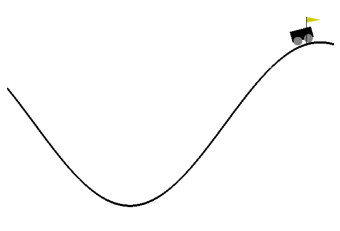

In [8]:
agent.load_state_dict(torch.load('checkpoint_mountainCont.pth', map_location='cpu'))


env = wrappers.Monitor(env, 'mountainCar', force=True)
state = env.reset()
img = plt.imshow(env.render(mode='rgb_array'))
while True:
    
    state = torch.from_numpy(state).float().to(device)
    action = agent(state)
    img.set_data(env.render(mode='rgb_array')) 
    plt.axis('off')
    display.display(plt.gcf())
    display.clear_output(wait=True)
    state, reward, done, _ = env.step(action)
#     epi_return += reward + math.pow(gamma, t)
#     t += 1
    if done:
        break


In [9]:
env.close()